In [ ]:
#Librerias para procesar datos
import pandas as pd
from datetime import datetime
import urllib.request
import numpy as np

# Librearías de gráficas
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px




# Librerias para modelo ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

# Comprobar la estacionariedad de la serie
from statsmodels.tsa.stattools import adfuller

import matplotlib.dates as mdates

from scipy import stats
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, SimpleRNN



from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import math

In [59]:
urls_epm = {
    'energia_activa_2020':'datos_originales/Energia Activa 2020.xlsx',
    'energia_activa_2021':'datos_originales/Energia activa 2021.xlsx',
    'energia_activa_2022':'datos_originales/Energia activa 2022.xlsx',
    'energia_2023':'datos_originales/agnios/2023',
    'energia_2024':'datos_originales/agnios/2024'
}
urls_sensores = {
    'iot_calderas'       :'https://raw.githubusercontent.com/Causil/especializacion/main/monografia/momentos_evaluativos/Momento%203/datos_originales/auralac_iot_calderas.csv',
    'iot_esterilizadores':'https://raw.githubusercontent.com/Causil/especializacion/main/monografia/momentos_evaluativos/Momento%203/datos_originales/auralac_iot_esterilizadores.csv',
    'iot_pasteurizadores':'https://raw.githubusercontent.com/Causil/especializacion/main/monografia/momentos_evaluativos/Momento%203/datos_originales/auralac_iot_pasteurizadores.csv',
    'iot_power_meters':'https://raw.githubusercontent.com/Causil/especializacion/main/monografia/momentos_evaluativos/Momento%203/datos_originales/auralac_iot_power_meters.csv',
    'iot_silos':'https://raw.githubusercontent.com/Causil/especializacion/main/monografia/momentos_evaluativos/Momento%203/datos_originales/auralac_iot_silos.csv',
    'iot_yogurteras':'https://raw.githubusercontent.com/Causil/especializacion/main/monografia/momentos_evaluativos/Momento%203/datos_originales/auralac_iot_yogurteras.csv',
    'iot_power_meters_act': "/home/javier/Documentos/Javier/MiPregradoDeVida/Postgrado/especializacion/monografia/momentos_evaluativos/DesarrolloMonografia/datos_originales/Datos monografia sensores.xlsx"
}

### Hechos en los datos 

Del experto en datos tenemos que el total de la energía consumida en la planta está determinada por las maquinas pm-2000kva + pm-1000kva + pm-300kva + pm-112kva + pm-538kwp. 


Eventos externos a los datos:
1. Descalibración en los sensores en Enero, provoco un registro erroneo en los datos.

# Datos de EPM

## Limpieza de datos

In [60]:
#Funciones 
def limpieza_datos(url_dataset:str, fila_final:int, columna_final:int):
    """ 
    Lee el excel y se encarga de extraer la información valiosa
    Parametros:
        url_dataset - text: dirección donde se encuentra en archivo con datos en github
        columna_final - int: la última columna que contiene datos en el archivo
        fila_final - int: la última fila que contiene datos en el archivo
    retorna: 
        DataFrame
    """ 
    df = pd.read_excel(url_dataset)
    xdf = df.iloc[15:fila_final,2:columna_final]
    xdf.iloc[0,0] = "date"
    xdf_sin_nan = xdf.dropna(how='all')
    xdf_sin_nan = xdf.dropna(axis=1)
    nuevos_nombres_columnas =  list(xdf_sin_nan.iloc[0])
    xdf_sin_nan.columns = nuevos_nombres_columnas
    xdf_sin_nan = xdf_sin_nan.reset_index(drop=True)
    xdf_sin_nan = xdf_sin_nan.drop(0)
    xdf_sin_nan = xdf_sin_nan.reset_index(drop=True)
    return xdf_sin_nan


def limpieza_datos_2023(url_dataset:str, fila_final:int, columna_final:int):
    """ 
    Lee el excel y se encarga de extraer la información valiosa
    Parametros:
        url_dataset - text: dirección donde se encuentra en archivo con datos en github
        columna_final - int: la última columna que contiene datos en el archivo
        fila_final - int: la última fila que contiene datos en el archivo
    retorna: 
        DataFrame
    """ 
    df = pd.read_excel(url_dataset)
    xdf = df.iloc[15:fila_final,2:columna_final]
    xdf.iloc[0,0] = "date"
    rows_with_nan = xdf[xdf.isna().any(axis=1)]
    if not(rows_with_nan.shape == (0,0)):
        xdf_sin_nan = xdf.dropna(how='all')
    xdf_sin_nan = xdf_sin_nan.dropna(axis=1)
    nuevos_nombres_columnas =  list(xdf_sin_nan.iloc[0])
    xdf_sin_nan.columns = nuevos_nombres_columnas
    xdf_sin_nan = xdf_sin_nan.reset_index(drop=True)
    xdf_sin_nan = xdf_sin_nan.drop(0)
    xdf_sin_nan = xdf_sin_nan.reset_index(drop=True)
    return xdf_sin_nan
    
def convert_to_datetime(column):
    """
    Cambia el tipo de dato a datatime
    """
    formats = ['%Y-%m-%dT%H:%M:%S.%f', '%Y-%m-%dT%H:%M:%S,%f']
    for fmt in formats:
        try:
            return pd.to_datetime(column, format=fmt)
        except ValueError:
            continue
    raise ValueError(f"Time data '{column}' does not match any known formats")

In [61]:
from funciones import multiple_plot, plot_roc_curve, tidy_corr_matrix, checkVIF

In [62]:
# Eliminar celdas y espacios vacios utilizando la función limpieza_datos.
energia_2020 = limpieza_datos(urls_epm["energia_activa_2020"], 336, 109)
energia_2021 = limpieza_datos(urls_epm["energia_activa_2021"], 381, 109)
energia_2022 = limpieza_datos(urls_epm["energia_activa_2022"], 381, 109)
#energia_2023 = limpieza_datos(urls_epm["energia_activa_2023"], 231, 109)


In [63]:
energia_2020

,date,Energía Activa Consumo\n(kWh),Energía Activa Generación\n(kWh),Energía Reactiva Inductiva\n(kVarh),Energía Reactiva Capacitiva\n(kVarh),Energía Activa Consumo\n(kWh),Energía Activa Generación\n(kWh),Energía Reactiva Inductiva\n(kVarh),Energía Reactiva Capacitiva\n(kVarh),Energía Activa Consumo\n(kWh),...,Energía Reactiva Inductiva\n(kVarh),Energía Reactiva Capacitiva\n(kVarh),Energía Activa Consumo\n(kWh),Energía Activa Generación\n(kWh),Energía Reactiva Inductiva\n(kVarh),Energía Reactiva Capacitiva\n(kVarh),Energía Activa Consumo\n(kWh),Energía Activa Generación\n(kWh),Energía Reactiva Inductiva\n(kVarh),Energía Reactiva Capacitiva\n(kVarh)
0,16/02/2020,322.32,0,0,0,356.64,0,0,0,375.36,...,158.4,0,362.6,0,179.2,0,377.2,0,178.4,0
1,17/02/2020,380.4,0,178.6,0,402.6,0,191.6,0,410.6,...,295.4,0,533.2,0,280,0,535.2,0,270.6,0
2,18/02/2020,603.2,0,300,0,606,0,292.8,0,616.4,...,356.2,0,604.2,0,296.6,0,567,0,275.8,0
3,19/02/2020,566.8,0,285.4,0,577,0,279.6,0,533,...,313,0,561.6,0,309,0,605.4,0,330.6,0
4,20/02/2020,611,0,328.6,0,621,0,339.2,0,613,...,266.4,0,572.8,0,292.8,0,576.2,0,292,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,27/12/2020,582.8,0,306.8,0,613,0,311.4,0,671.6,...,323.8,0,609,0,320.8,0,548.4,0,304.2,0
316,28/12/2020,545.8,0,296,0,558.2,0,299.6,0,502.2,...,375,0,720.4,0,396.2,0,706.8,0,387,0
317,29/12/2020,703.4,0,357.8,0,636,0,320.6,0,735.8,...,356,0,645,0,368.8,0,605.6,0,346,0
318,30/12/2020,579,0,336.2,0,600.8,0,322.8,0,585.4,...,317.8,0,623.6,0,317.6,0,663,0,358.8,0


In [64]:
import os
import re
from datetime import datetime
import calendar
meses_espanol = {
    'Enero':      1,
    'Febrero':    2,
    'Marzo':      3,
    'Abril':      4,
    'Mayo':       5,
    'Junio':      6,
    'Julio':      7,
    'Agosto':     8,
    'Septiembre': 9,
    'Octubre':    10,
    'Noviembre':  11,
    'Diciembre':  12
}

# Define la ruta de la carpeta
folder_path = urls_epm["energia_2024"]

# Lista todos los archivos en la carpeta que terminan en .xlsx
xlsx_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.xlsx')])
print(xlsx_files)
def extraer_fecha(nombre_archivo):
    # Utilizamos una expresión regular para capturar el mes y el año
    match = re.search(r'(\w+)\s(\d{4})', nombre_archivo)
    if match:
        mes = match.group(1)
        anio = int(match.group(2))
        print(mes,anio)
        # Buscar el mes en el diccionario de meses en español
        if mes in meses_espanol:
            mes_num = meses_espanol[mes]
            return anio, mes_num
    return None

# Lista para almacenar los DataFrames de cada archivo
dataframes_concatenados_2024 = []

for ruta in xlsx_files:
    fecha = extraer_fecha(ruta)
    
    print(ruta, fecha)
    if fecha:
        anio, mes = fecha
        # Calcula el número de días en el mes
        dias_en_mes = calendar.monthrange(anio, mes)[1]
        # Procesa el archivo y obtiene el DataFrame correspondiente
        mes_ = limpieza_datos(f"{urls_epm['energia_2024']}/{ruta}", dias_en_mes + 15, 109)
        # Agrega el DataFrame procesado a la lista
        dataframes_concatenados_2024.append(mes_)

# Concatenar todos los DataFrames en uno solo
energia_2024 = pd.concat(dataframes_concatenados_2024)
        

['01 Enero 2024.xlsx', '02  Febrero 2024.xlsx', '03. Marzo 2024.xlsx', '04. Abril 2024.xlsx', '05 Mayo 2024.xlsx', '06 Junio 2024.xlsx', '07 Julio 2024.xlsx', '08 Agosto 2024.xlsx', '09 Septiembre 2024.xlsx']
Enero 2024
01 Enero 2024.xlsx (2024, 1)
Febrero 2024
02  Febrero 2024.xlsx (2024, 2)
Marzo 2024
03. Marzo 2024.xlsx (2024, 3)
Abril 2024
04. Abril 2024.xlsx (2024, 4)
Mayo 2024
05 Mayo 2024.xlsx (2024, 5)
Junio 2024
06 Junio 2024.xlsx (2024, 6)
Julio 2024
07 Julio 2024.xlsx (2024, 7)
Agosto 2024
08 Agosto 2024.xlsx (2024, 8)
Septiembre 2024
09 Septiembre 2024.xlsx (2024, 9)


In [65]:
meses_espanol = {
    'Enero':      1,
    'Febrero':    2,
    'Marzo':      3,
    'Abril':      4,
    'Mayo':       5,
    'Junio':      6,
    'Julio':      7,
    'Agosto':     8,
    'Septiembre': 9,
    'Octubre':    10,
    'Noviembre':  11,
    'Diciembre':  12
}

# Define la ruta de la carpeta
folder_path = urls_epm["energia_2023"]

# Lista todos los archivos en la carpeta que terminan en .xlsx
xlsx_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.xlsx')])
print(xlsx_files)
def extraer_fecha(nombre_archivo):
    # Utilizamos una expresión regular para capturar el mes y el año
    match = re.search(r'(\w+)\s(\d{4})', nombre_archivo)
    print("nombre_archivo, match",nombre_archivo,match)
    if match:
        mes = match.group(1)
        anio = int(match.group(2))
        print(nombre_archivo,mes,anio)
        # Buscar el mes en el diccionario de meses en español
        if mes in meses_espanol:
            mes_num = meses_espanol[mes]
            return anio, mes_num
    return None

# Lista para almacenar los DataFrames de cada archivo
dataframes_concatenados_2023 = []

for ruta in xlsx_files:
    fecha = extraer_fecha(ruta)
    print(ruta, fecha)
    if fecha:
        anio, mes = fecha
        # Calcula el número de días en el mes
        dias_en_mes = calendar.monthrange(anio, mes)[1]
        # Procesa el archivo y obtiene el DataFrame correspondiente
        path_file = f"datos_originales/agnios/2023/{ruta}"
        mes_ = limpieza_datos(path_file, dias_en_mes + 15, 109)
        print(path_file,dias_en_mes)
        
        # Agrega el DataFrame procesado a la lista
        dataframes_concatenados_2023.append(mes_)

# Concatenar todos los DataFrames en uno solo
energia_2023 = pd.concat(dataframes_concatenados_2023)

['01. Enero 2023 VipRptMatrixActivaReactivaEncursoPpal.xlsx', '02. Febrero 2023 VipRptMatrixActivaReactivaEncursoPpal.xlsx', '03. Marzo 2023 VipRptMatrixActivaReactivaEncursoPpal.xlsx', '04. Abril 2023 VipRptMatrixActivaReactivaEncursoPpal.xlsx', '05. Mayo 2023 VipRptMatrixActivaReactivaEncursoPpal.xlsx', '06. Junio 2023 VipRptMatrixActivaReactivaEncursoPpal.xlsx', '07. Julio 2023.xlsx', '08. Agosto 2023 VipRptMatrixActivaReactivaEncursoPpal.xlsx', '09. Septiembre 2023 VipRptMatrixActivaReactivaEncursoPpal (5).xlsx', '10. Octubre 2023 VipRptMatrixActivaReactivaEncursoPpal (6).xlsx', '11. Noviembre 2023 VipRptMatrixActivaReactivaEncursoPpal (7).xlsx', '12. Diciembre 2023 VipRptMatrixActivaReactivaEncursoPpal (8).xlsx']
nombre_archivo, match 01. Enero 2023 VipRptMatrixActivaReactivaEncursoPpal.xlsx <re.Match object; span=(4, 14), match='Enero 2023'>
01. Enero 2023 VipRptMatrixActivaReactivaEncursoPpal.xlsx Enero 2023
01. Enero 2023 VipRptMatrixActivaReactivaEncursoPpal.xlsx (2023, 1)
dat

In [66]:
energia_2023

,date,Energía Activa Consumo\n(kWh),Energía Activa Generación\n(kWh),Energía Reactiva Inductiva\n(kVarh),Energía Reactiva Capacitiva\n(kVarh),Energía Activa Consumo\n(kWh),Energía Activa Generación\n(kWh),Energía Reactiva Inductiva\n(kVarh),Energía Reactiva Capacitiva\n(kVarh),Energía Activa Consumo\n(kWh),...,Energía Reactiva Inductiva\n(kVarh),Energía Reactiva Capacitiva\n(kVarh),Energía Activa Consumo\n(kWh),Energía Activa Generación\n(kWh),Energía Reactiva Inductiva\n(kVarh),Energía Reactiva Capacitiva\n(kVarh),Energía Activa Consumo\n(kWh),Energía Activa Generación\n(kWh),Energía Reactiva Inductiva\n(kVarh),Energía Reactiva Capacitiva\n(kVarh)
0,01/01/2023,304,0,169.8,0,305,0,169.4,0,305.8,...,276.6,0,788.4,0,368.6,0,918.8,0,412.4,0
1,02/01/2023,955.8,0,420.8,0,855.4,0,374.4,0,921,...,412.4,0,870.4,0,370.2,0,885,0,394.2,0
2,03/01/2023,862.6,0,375.6,0,754.8,0,342.6,0,632.6,...,398.8,0,824,0,389,0,848.2,0,393.4,0
3,04/01/2023,719.4,0,350,0,692.8,0,352.4,0,742.4,...,303.8,0,737.4,0,348.8,0,781,0,377.6,0
4,05/01/2023,769.4,0,357.2,0,774,0,367.2,0,768.2,...,351.2,0,798.6,0,341,0,775.6,0,388,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25,26/12/2023,1007.4,0,492,0,814.2,0,393.6,0,979.2,...,534.6,0,1112.4,0,528,0,1113.6,0,509.4,0
26,27/12/2023,1109.4,0,520.8,0,1131,0,504.6,0,1054.2,...,521.4,0,961.8,0,505.8,0,947.4,0,487.2,0
27,28/12/2023,932.4,0,492,0,910.8,0,481.2,0,876,...,343.8,0,659.4,0,339.6,0,645,0,355.8,0
28,29/12/2023,692.4,0,397.8,0,690,0,391.8,0,718.8,...,426,0,801,0,366.6,0,976.2,0,475.8,0


In [67]:
energia_2020.head()

,date,Energía Activa Consumo\n(kWh),Energía Activa Generación\n(kWh),Energía Reactiva Inductiva\n(kVarh),Energía Reactiva Capacitiva\n(kVarh),Energía Activa Consumo\n(kWh),Energía Activa Generación\n(kWh),Energía Reactiva Inductiva\n(kVarh),Energía Reactiva Capacitiva\n(kVarh),Energía Activa Consumo\n(kWh),...,Energía Reactiva Inductiva\n(kVarh),Energía Reactiva Capacitiva\n(kVarh),Energía Activa Consumo\n(kWh),Energía Activa Generación\n(kWh),Energía Reactiva Inductiva\n(kVarh),Energía Reactiva Capacitiva\n(kVarh),Energía Activa Consumo\n(kWh),Energía Activa Generación\n(kWh),Energía Reactiva Inductiva\n(kVarh),Energía Reactiva Capacitiva\n(kVarh)
0,16/02/2020,322.32,0,0,0,356.64,0,0,0,375.36,...,158.4,0,362.6,0,179.2,0,377.2,0,178.4,0
1,17/02/2020,380.4,0,178.6,0,402.6,0,191.6,0,410.6,...,295.4,0,533.2,0,280,0,535.2,0,270.6,0
2,18/02/2020,603.2,0,300,0,606,0,292.8,0,616.4,...,356.2,0,604.2,0,296.6,0,567,0,275.8,0
3,19/02/2020,566.8,0,285.4,0,577,0,279.6,0,533,...,313,0,561.6,0,309,0,605.4,0,330.6,0
4,20/02/2020,611,0,328.6,0,621,0,339.2,0,613,...,266.4,0,572.8,0,292.8,0,576.2,0,292,0


In [68]:
energia_2021.head()

,date,Energía Activa Consumo\n(kWh),Energía Activa Generación\n(kWh),Energía Reactiva Inductiva\n(kVarh),Energía Reactiva Capacitiva\n(kVarh),Energía Activa Consumo\n(kWh),Energía Activa Generación\n(kWh),Energía Reactiva Inductiva\n(kVarh),Energía Reactiva Capacitiva\n(kVarh),Energía Activa Consumo\n(kWh),...,Energía Reactiva Inductiva\n(kVarh),Energía Reactiva Capacitiva\n(kVarh),Energía Activa Consumo\n(kWh),Energía Activa Generación\n(kWh),Energía Reactiva Inductiva\n(kVarh),Energía Reactiva Capacitiva\n(kVarh),Energía Activa Consumo\n(kWh),Energía Activa Generación\n(kWh),Energía Reactiva Inductiva\n(kVarh),Energía Reactiva Capacitiva\n(kVarh)
0,01/01/2021,237.2,0,138,0,230.8,0,126,0,241.4,...,193.4,0,365,0,205.2,0,486.6,0,248.8,0
1,02/01/2021,562.8,0,309,0,571.6,0,308.2,0,593.8,...,215.4,0,346.6,0,221.2,0,369.2,0,228.2,0
2,03/01/2021,385.6,0,240.4,0,378.8,0,234.4,0,434.6,...,251,0,553,0,291.6,0,544,0,289.2,0
3,04/01/2021,548.8,0,279.8,0,655.2,0,328.2,0,658.6,...,298.6,0,544.6,0,285.8,0,546.2,0,291.4,0
4,05/01/2021,548.2,0,286,0,611,0,304.6,0,657.4,...,313.4,0,550.6,0,286.6,0,548.4,0,284.4,0


In [69]:
energia_2023

,date,Energía Activa Consumo\n(kWh),Energía Activa Generación\n(kWh),Energía Reactiva Inductiva\n(kVarh),Energía Reactiva Capacitiva\n(kVarh),Energía Activa Consumo\n(kWh),Energía Activa Generación\n(kWh),Energía Reactiva Inductiva\n(kVarh),Energía Reactiva Capacitiva\n(kVarh),Energía Activa Consumo\n(kWh),...,Energía Reactiva Inductiva\n(kVarh),Energía Reactiva Capacitiva\n(kVarh),Energía Activa Consumo\n(kWh),Energía Activa Generación\n(kWh),Energía Reactiva Inductiva\n(kVarh),Energía Reactiva Capacitiva\n(kVarh),Energía Activa Consumo\n(kWh),Energía Activa Generación\n(kWh),Energía Reactiva Inductiva\n(kVarh),Energía Reactiva Capacitiva\n(kVarh)
0,01/01/2023,304,0,169.8,0,305,0,169.4,0,305.8,...,276.6,0,788.4,0,368.6,0,918.8,0,412.4,0
1,02/01/2023,955.8,0,420.8,0,855.4,0,374.4,0,921,...,412.4,0,870.4,0,370.2,0,885,0,394.2,0
2,03/01/2023,862.6,0,375.6,0,754.8,0,342.6,0,632.6,...,398.8,0,824,0,389,0,848.2,0,393.4,0
3,04/01/2023,719.4,0,350,0,692.8,0,352.4,0,742.4,...,303.8,0,737.4,0,348.8,0,781,0,377.6,0
4,05/01/2023,769.4,0,357.2,0,774,0,367.2,0,768.2,...,351.2,0,798.6,0,341,0,775.6,0,388,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25,26/12/2023,1007.4,0,492,0,814.2,0,393.6,0,979.2,...,534.6,0,1112.4,0,528,0,1113.6,0,509.4,0
26,27/12/2023,1109.4,0,520.8,0,1131,0,504.6,0,1054.2,...,521.4,0,961.8,0,505.8,0,947.4,0,487.2,0
27,28/12/2023,932.4,0,492,0,910.8,0,481.2,0,876,...,343.8,0,659.4,0,339.6,0,645,0,355.8,0
28,29/12/2023,692.4,0,397.8,0,690,0,391.8,0,718.8,...,426,0,801,0,366.6,0,976.2,0,475.8,0


In [70]:
energia_2024.tail()

,date,Energía Activa Consumo\n(kWh),Energía Activa Generación\n(kWh),Energía Reactiva Inductiva\n(kVarh),Energía Reactiva Capacitiva\n(kVarh),Energía Activa Consumo\n(kWh),Energía Activa Generación\n(kWh),Energía Reactiva Inductiva\n(kVarh),Energía Reactiva Capacitiva\n(kVarh),Energía Activa Consumo\n(kWh),...,Energía Reactiva Inductiva\n(kVarh),Energía Reactiva Capacitiva\n(kVarh),Energía Activa Consumo\n(kWh),Energía Activa Generación\n(kWh),Energía Reactiva Inductiva\n(kVarh),Energía Reactiva Capacitiva\n(kVarh),Energía Activa Consumo\n(kWh),Energía Activa Generación\n(kWh),Energía Reactiva Inductiva\n(kVarh),Energía Reactiva Capacitiva\n(kVarh)
24,25/09/2024,1011,0,476.4,0,966,0,422.4,0,956.4,...,450,0,970.8,0,433.2,0,1027.8,0,479.4,0
25,26/09/2024,975.6,0,462.6,0,1034.4,0,480.6,0,1044,...,442.8,0,1071.6,0,487.2,0,1095,0,524.4,0
26,27/09/2024,1049.4,0,505.8,0,1060.2,0,487.2,0,1140,...,502.2,0,1031.4,0,435.6,0,1110,0,490.2,0
27,28/09/2024,973.8,0,442.2,0,988.8,0,456,0,949.8,...,412.8,0,724.8,0,362.4,0,838.2,0,443.4,0
28,29/09/2024,883.2,0,436.2,0,864.6,0,406.2,0,994.8,...,450,0,939.6,0,408,0,1071.6,0,494.4,0


In [71]:
# Agrupamos y sumamos la información para que quede por días
df_energia_epm = pd.concat([energia_2020, energia_2021, energia_2022, energia_2023, energia_2024]).T.groupby(level=0).sum().T
df_energia_epm.columns = ["activa_consumo", "activa_generación", "reactiva_capacitiva", "reactiva_inductiva", "date"]

In [72]:
df_energia_epm

,activa_consumo,activa_generación,reactiva_capacitiva,reactiva_inductiva,date
0,4946.56,0,0,1381.8,16/02/2020
1,14396.4,0,0,7070.0,17/02/2020
2,14897.0,0,0,7641.8,18/02/2020
3,14972.6,0,0,7799.6,19/02/2020
4,16106.6,0,0,8379.0,20/02/2020
...,...,...,...,...,...
24,21329.4,0,0,10614.0,25/09/2024
25,22014.0,0,0,11338.8,26/09/2024
26,21686.4,0,0,11155.8,27/09/2024
27,22089.6,0,0,10884.6,28/09/2024


In [73]:
df_energia_epm['date'] = pd.to_datetime(df_energia_epm['date'], format='%d/%m/%Y')
type_datos = {
    'activa_consumo': 'float16',
    'activa_generación': 'float16',
    'reactiva_capacitiva': 'float16',
    'reactiva_inductiva': 'float16'
}
df_energia_epm = df_energia_epm.astype(type_datos)

La data tiene un periodo por días. 

In [74]:
df_energia_epm.to_parquet("datos_procesados/df_energia_epm.parquet")

In [75]:
df_energia_epm.describe()

/home/javier/.local/lib/python3.10/site-packages/numpy/core/_methods.py:49: RuntimeWarning:

overflow encountered in reduce

/home/javier/.local/lib/python3.10/site-packages/pandas/core/nanops.py:1010: RuntimeWarning:

overflow encountered in square

/home/javier/.local/lib/python3.10/site-packages/numpy/core/_methods.py:49: RuntimeWarning:

overflow encountered in reduce

/home/javier/.local/lib/python3.10/site-packages/pandas/core/nanops.py:1010: RuntimeWarning:

overflow encountered in square



,activa_consumo,activa_generación,reactiva_capacitiva,reactiva_inductiva,date
count,1668.0,1668.000000,1668.000000,1668.0,1668
mean,inf,0.665039,0.008156,inf,2022-06-02 05:06:28.489208576
min,4948.0,0.000000,0.000000,1382.0,2020-02-16 00:00:00
25%,15712.0,0.000000,0.000000,8192.0,2021-04-07 18:00:00
50%,17232.0,0.000000,0.000000,9024.0,2022-05-29 12:00:00
75%,18784.0,0.000000,0.000000,10026.0,2023-07-26 06:00:00
max,25520.0,115.187500,9.000000,13096.0,2024-09-29 00:00:00
std,inf,6.199219,0.234863,inf,NaN


In [76]:
df_energia_epm

,activa_consumo,activa_generación,reactiva_capacitiva,reactiva_inductiva,date
0,4948.0,0.0,0.0,1382.0,2020-02-16
1,14400.0,0.0,0.0,7072.0,2020-02-17
2,14896.0,0.0,0.0,7640.0,2020-02-18
3,14976.0,0.0,0.0,7800.0,2020-02-19
4,16104.0,0.0,0.0,8376.0,2020-02-20
...,...,...,...,...,...
24,21328.0,0.0,0.0,10616.0,2024-09-25
25,22016.0,0.0,0.0,11336.0,2024-09-26
26,21680.0,0.0,0.0,11152.0,2024-09-27
27,22096.0,0.0,0.0,10888.0,2024-09-28


### Analizando la data

In [77]:
df_energia_epm.index = df_energia_epm['date']

In [78]:
df_energia_epm

,activa_consumo,activa_generación,reactiva_capacitiva,reactiva_inductiva,date
date,,,,,
2020-02-16,4948.0,0.0,0.0,1382.0,2020-02-16
2020-02-17,14400.0,0.0,0.0,7072.0,2020-02-17
2020-02-18,14896.0,0.0,0.0,7640.0,2020-02-18
2020-02-19,14976.0,0.0,0.0,7800.0,2020-02-19
2020-02-20,16104.0,0.0,0.0,8376.0,2020-02-20
...,...,...,...,...,...
2024-09-25,21328.0,0.0,0.0,10616.0,2024-09-25
2024-09-26,22016.0,0.0,0.0,11336.0,2024-09-26
2024-09-27,21680.0,0.0,0.0,11152.0,2024-09-27


In [79]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [80]:
training_set = df_energia_epm[:'2023'].iloc[:,3:4].values
test_set = df_energia_epm['2024':].iloc[:,3:4].values
#test_set[np.isnan(test_set)] = df_energia_epm['reactiva_inductiva'].max()

In [81]:
training_set

array([[ 1382.],
       [ 7072.],
       [ 7640.],
       ...,
       [ 9768.],
       [ 9944.],
       [10704.]], dtype=float16)

In [82]:
test_set

array([[ 6936.],
       [11200.],
       [10304.],
       [10664.],
       [10088.],
       [10240.],
       [10472.],
       [11312.],
       [10840.],
       [11216.],
       [10968.],
       [11344.],
       [ 9856.],
       [ 5984.],
       [10840.],
       [11824.],
       [11384.],
       [10960.],
       [10400.],
       [ 9528.],
       [ 9728.],
       [10312.],
       [10408.],
       [10824.],
       [10280.],
       [11168.],
       [10440.],
       [10320.],
       [10576.],
       [10424.],
       [10704.],
       [ 9272.],
       [ 9352.],
       [ 8944.],
       [ 9584.],
       [10224.],
       [10072.],
       [ 9360.],
       [ 9328.],
       [ 9800.],
       [ 9368.],
       [10008.],
       [11192.],
       [10448.],
       [11520.],
       [10816.],
       [10672.],
       [10232.],
       [10176.],
       [11464.],
       [11328.],
       [10928.],
       [10408.],
       [10624.],
       [ 7428.],
       [ 9976.],
       [ 9872.],
       [10680.],
       [10960.

In [83]:
import plotly.graph_objects as go

# Definir los datos para el conjunto de entrenamiento y prueba
training_data = df_energia_epm["reactiva_inductiva"][:'2023']
test_data = df_energia_epm["reactiva_inductiva"]['2024':]

# Crear la figura
fig = go.Figure()

# Añadir la serie de datos del conjunto de entrenamiento
fig.add_trace(go.Scatter(
    x=training_data.index,
    y=training_data.values,
    mode='lines',
    name='Training set (Before 2024)'
))

# Añadir la serie de datos del conjunto de prueba
fig.add_trace(go.Scatter(
    x=test_data.index,
    y=test_data.values,
    mode='lines',
    name='Test set (2024 and beyond)'
))

# Configurar el diseño del gráfico
fig.update_layout(
    title="Energía reactiva inductiva de EPM",
    xaxis_title="Date",
    yaxis_title="Reactiva Inductiva",
    legend=dict(title="Data"),
    width=1000, # Ajustar el ancho en lugar de figsize
    height=400
)

# Mostrar el gráfico
fig.show()


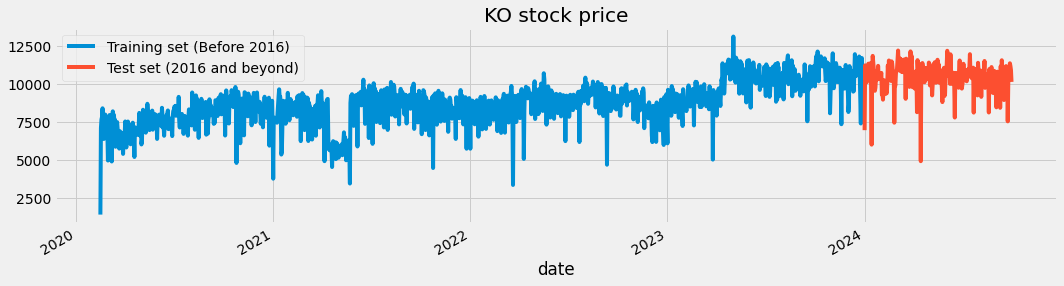

In [84]:
df_energia_epm["reactiva_inductiva"][:'2023'].plot(figsize=(16,4),legend=True)
df_energia_epm["reactiva_inductiva"]['2024':].plot(figsize=(16,4),legend=True)
plt.legend(['Training set (Before 2016)','Test set (2016 and beyond)'])
plt.title('KO stock price')
plt.show()

In [85]:
# Visualiza la serie temporal

#plt.plot(data_day['date'], df_er)
fig = px.line(df_energia_epm, x='date', y='reactiva_inductiva', title='Energía Reactiva en el Tiempo')

# Personalización del gráfico
fig.update_layout(
    title='Energía Reactiva en el Tiempo EPM',
    xaxis_title='Fecha',
    yaxis_title='Energía Reactiva',
    xaxis_rangeslider_visible=True,  # Agregar slider para seleccionar el rango de fechas
    width=1400,
    height=800
)

fig.show()

In [86]:
moda    = df_energia_epm["reactiva_inductiva"].mode()
mediana = df_energia_epm["reactiva_inductiva"].median()
media   = df_energia_epm["reactiva_inductiva"].mean()
print(mediana,media)

9020.0 inf


/home/javier/.local/lib/python3.10/site-packages/numpy/core/_methods.py:49: RuntimeWarning:

overflow encountered in reduce



In [87]:
Q1 = df_energia_epm["reactiva_inductiva"].quantile(0.25)
Q3 = df_energia_epm["reactiva_inductiva"].quantile(0.75)
IQR = Q3 - Q1

# Definir límites para detectar outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identificar los outliers
outliers = df_energia_epm["reactiva_inductiva"][(df_energia_epm["reactiva_inductiva"] < lower_bound) | (df_energia_epm["reactiva_inductiva"] > upper_bound)]

In [88]:
outliers

date
2020-02-16     1382.0
2020-03-01     4940.0
2020-03-08     4876.0
2020-03-29     5376.0
2020-04-19     5172.0
2020-10-25     4780.0
2021-01-01     3744.0
2021-01-16     5332.0
2021-04-06     4896.0
2021-04-20     4512.0
2021-04-27     5032.0
2021-05-02     5124.0
2021-05-06     5388.0
2021-05-09     5288.0
2021-05-16     4956.0
2021-05-23     3426.0
2021-10-24     4448.0
2022-03-21     3332.0
2022-04-10     5044.0
2022-09-11     4664.0
2023-03-26     5000.0
2023-05-03    13096.0
2024-04-14     4896.0
Name: reactiva_inductiva, dtype: float16

In [89]:
from statsmodels.tsa.stattools import adfuller

# Realizar la prueba de Dickey-Fuller Aumentada
result = adfuller(df_energia_epm["reactiva_inductiva"])
print(f'Estadístico de ADF: {result[0]}')
print(f'p-valor: {result[1]}')
print('Critical Values:', result[4])

Estadístico de ADF: -2.5129155641943317
p-valor: 0.11236337093538501
Critical Values: {'1%': -3.4343363335985666, '5%': -2.8633007375690576, '10%': -2.5677073765535114}


Interpretación de los Resultados:
Estadístico de ADF (-2.4044703204821882): Este es el valor calculado del estadístico de la prueba de Dickey-Fuller. Este valor se compara con los valores críticos para diferentes niveles de significancia (1%, 5%, y 10%).

p-valor (0.140478667020226136): El p-valor es una métrica clave en la prueba. Aquí el p-valor es 0.14, lo cual es mayor que los valores de significancia comunes (por ejemplo, 0.05). Esto indica que no podemos rechazar la hipótesis nula, que establece que la serie tiene una raíz unitaria y, por lo tanto, no es estacionaria.

Valores críticos:

1%: -3.435097467737946
5%: -2.863636658797804
10%: -2.5678862576139467
Estos valores críticos te permiten comparar el estadístico de ADF y decidir si rechazar o no la hipótesis nula:

Si el estadístico de ADF es más bajo (más negativo) que el valor crítico para un determinado nivel de significancia, se puede rechazar la hipótesis nula y concluir que la serie es estacionaria.
En tu caso, el estadístico de ADF (-2.4044) es mayor que los valores críticos a todos los niveles de significancia, por lo que no se puede rechazar la hipótesis nula.

Conclusión:
Con base en el p-valor y el estadístico de ADF, no puedes rechazar la hipótesis nula de que la serie tiene una raíz unitaria, lo que significa que la serie no es estacionaria. Esto implica que, para modelar esta serie (por ejemplo, en un modelo ARIMA), probablemente necesitarás aplicar alguna transformación como diferenciación para hacerla estacionaria antes de continuar con el análisis.



In [90]:
# Diferenciar la serie
df_energia_epm['reactiva_inductiva_diff'] = df_energia_epm['reactiva_inductiva'].diff()

# Realizar la prueba de ADF nuevamente
result_diff = adfuller(df_energia_epm['reactiva_inductiva_diff'].dropna())
print(f'Estadístico de ADF: {result_diff[0]}')
print(f'p-valor: {result_diff[1]}')
print('Critical Values:', result_diff[4])

Estadístico de ADF: -10.202827382198528
p-valor: 5.90875988919773e-18
Critical Values: {'1%': -3.4343339050195465, '5%': -2.8632996655963554, '10%': -2.567706805740553}


In [91]:
# df_energia_epm['reactiva_inductiva_diff']
# Visualiza la serie temporal

#plt.plot(data_day['date'], df_er)
fig = px.line(df_energia_epm, x='date', y='reactiva_inductiva_diff', title='Energía Reactiva en el Tiempo')

# Personalización del gráfico
fig.update_layout(
    title='Energía Reactiva diff en el Tiempo EPM',
    xaxis_title='Fecha',
    yaxis_title='Energía Reactiva',
    xaxis_rangeslider_visible=True,  # Agregar slider para seleccionar el rango de fechas
    width=1400,
    height=800
)

fig.show()

In [92]:
df_energia_epm.set_index('date', inplace=True)

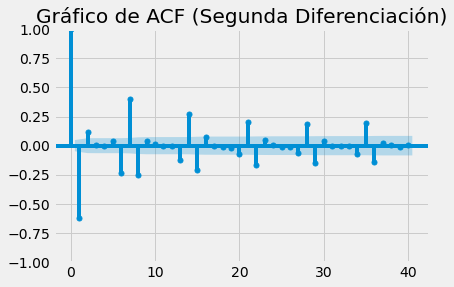

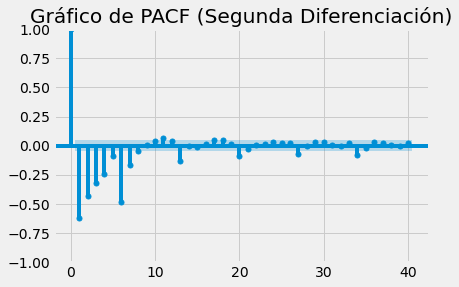

In [93]:
# Segunda diferenciación
df_energia_epm['reactiva_inductiva_diff2'] = df_energia_epm['reactiva_inductiva_diff'].diff()

# Graficar la ACF y PACF de la serie dos veces diferenciada
plot_acf(df_energia_epm['reactiva_inductiva_diff2'].dropna(), lags=40)
plt.title('Gráfico de ACF (Segunda Diferenciación)')
plt.show()

plot_pacf(df_energia_epm['reactiva_inductiva_diff2'].dropna(), lags=40)
plt.title('Gráfico de PACF (Segunda Diferenciación)')
plt.show()


In [94]:
df_energia_epm['reactiva_inductiva'] = pd.to_numeric(df_energia_epm['reactiva_inductiva'], errors='coerce')


In [95]:
from statsmodels.tsa.arima.model import ARIMA

# Ajustar el modelo ARIMA con (p=1, d=2, q=1)
model = ARIMA(df_energia_epm['reactiva_inductiva'], order=(1, 2, 1))

# Entrenar el modelo
model_fit = model.fit()

# Mostrar el resumen del modelo
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:     reactiva_inductiva   No. Observations:                 1668
Model:                 ARIMA(1, 2, 1)   Log Likelihood              -13844.439
Date:                Wed, 13 Nov 2024   AIC                          27694.878
Time:                        21:49:56   BIC                          27711.133
Sample:                             0   HQIC                         27700.902
                               - 1668                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3913      0.014    -28.121      0.000      -0.419      -0.364
ma.L1         -1.0000      0.021    -48.591      0.000      -1.040      -0.960
sigma2      9.632e+05   2.14e-08   4.51e+13      0.0

/home/javier/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/home/javier/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/home/javier/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



In [96]:
predictions = model_fit.predict(start=0, end=len(df_energia_epm['reactiva_inductiva']) - 1)

# Calcular métricas de rendimiento
mse = mean_squared_error(df_energia_epm['reactiva_inductiva'], predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(df_energia_epm['reactiva_inductiva'], predictions)

# Mostrar métricas
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")

Mean Squared Error (MSE): 986826.65
Root Mean Squared Error (RMSE): 993.39
Mean Absolute Error (MAE): 698.48


In [97]:
predictions

date
2020-02-16        0.000000
2020-02-17     1907.308959
2020-02-18     9042.096348
2020-02-19    10985.946427
2020-02-20    10319.569474
                  ...     
2024-09-25    10668.065984
2024-09-26    10805.086408
2024-09-27    11062.094716
2024-09-28    11231.892691
2024-09-29    10998.991079
Name: predicted_mean, Length: 1668, dtype: float64

In [98]:
df_energia_epm['reactiva_inductiva']

date
2020-02-16     1382.0
2020-02-17     7072.0
2020-02-18     7640.0
2020-02-19     7800.0
2020-02-20     8376.0
               ...   
2024-09-25    10616.0
2024-09-26    11336.0
2024-09-27    11152.0
2024-09-28    10888.0
2024-09-29    10112.0
Name: reactiva_inductiva, Length: 1668, dtype: float16

In [99]:
math.sqrt(r2_score(df_energia_epm['reactiva_inductiva'], predictions))

/home/javier/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1198: RuntimeWarning:

overflow encountered in square



1.0

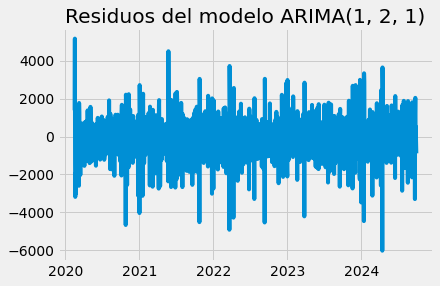

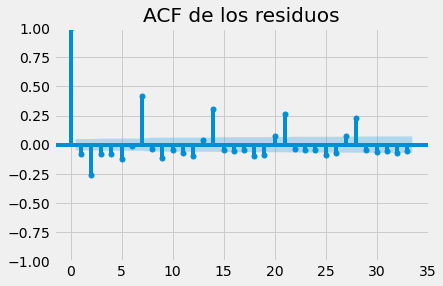

In [100]:
residuals = model_fit.resid
plt.plot(residuals)
plt.title('Residuos del modelo ARIMA(1, 2, 1)')
plt.show()

# Graficar ACF de los residuos
plot_acf(residuals)
plt.title('ACF de los residuos')
plt.show()

In [101]:
# Predecir los próximos 10 períodos
predicciones_futuras = model_fit.forecast(steps=30)
print(predicciones_futuras)

1668    10422.809640
1669    10308.340106
1670    10360.286446
1671    10347.112637
1672    10359.420975
1673    10361.757901
1674    10367.996738
1675    10372.708719
1676    10378.018173
1677    10383.093831
1678    10388.260975
1679    10393.392320
1680    10398.537673
1681    10403.677545
1682    10408.819562
1683    10413.960739
1684    10419.102245
1685    10424.243623
1686    10429.385050
1687    10434.526458
1688    10439.667874
1689    10444.809287
1690    10449.950700
1691    10455.092114
1692    10460.233527
1693    10465.374941
1694    10470.516354
1695    10475.657768
1696    10480.799181
1697    10485.940595
Name: predicted_mean, dtype: float64


/home/javier/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/home/javier/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



In [102]:
predicciones_in_sample = model_fit.predict(start=0, end=len(df_energia_epm['reactiva_inductiva']) - 1, dynamic=False)


In [103]:
import plotly.graph_objects as go

# Crear la figura
fig = go.Figure()

# Añadir la serie original de datos reales (reactiva_inductiva)
fig.add_trace(go.Scatter(x=df_energia_epm.index, y=df_energia_epm['reactiva_inductiva'],
                         mode='lines', name='Datos Reales'))

# Añadir las predicciones in-sample (predicciones hechas por el modelo ARIMA)
fig.add_trace(go.Scatter(x=df_energia_epm.index, y=predicciones_in_sample,
                         mode='lines', name='Predicciones ARIMA', line=dict(color='red')))

# Personalización del gráfico
fig.update_layout(
    title='Predicciones ARIMA vs Datos Reales (In-sample)',
    xaxis_title='Fecha',
    yaxis_title='Energía Reactiva',
    legend=dict(x=0, y=1),  # Posición de la leyenda
    width=1000,
    height=600
)

# Mostrar el gráfico interactivo
fig.show()


In [104]:
# Evaluar el RMSE
rmse = np.sqrt(mean_squared_error(df_energia_epm['reactiva_inductiva'], predicciones_in_sample))
print(f'RMSE (In-sample): {rmse}')

# Evaluar el MAE
mae = mean_absolute_error(df_energia_epm['reactiva_inductiva'], predicciones_in_sample)
print(f'MAE (In-sample): {mae}')

RMSE (In-sample): 993.3914871229796
MAE (In-sample): 698.475675686821


In [105]:
# Probar otro conjunto de parámetros ARIMA, por ejemplo (2, 2, 3)
model = ARIMA(df_energia_epm['reactiva_inductiva'], order=(2, 2, 3))
model_fit = model.fit()

/home/javier/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/home/javier/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/home/javier/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/home/javier/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



In [106]:
# Mostrar el resumen del modelo
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:     reactiva_inductiva   No. Observations:                 1668
Model:                 ARIMA(2, 2, 3)   Log Likelihood              -13632.434
Date:                Wed, 13 Nov 2024   AIC                          27276.869
Time:                        21:49:57   BIC                          27309.378
Sample:                             0   HQIC                         27288.916
                               - 1668                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8242      0.024    -34.739      0.000      -0.871      -0.778
ar.L2          0.1627      0.023      7.046      0.000       0.117       0.208
ma.L1         -0.8913      4.894     -0.182      0.8

# Cargando datos de los sensores


### Cargando datos desde el local

In [107]:
#Cargando datos
iot_power_meters_act = pd.read_excel(urls_sensores.get('iot_power_meters_act'))

Vamos a eliminar los equipos que no le aportan a la energía reactiva.

Los equipos que no le aportan a la energía reactiva teniendo presente los que aportan, pm-2000kva, pm-1000kva, pm-300kva, Pm-112 y pm-538kwp. 

In [108]:
# Estos equipos le aportan a la energía reactiva
valores_permitidos = [
    "pm-2000kva",
    "pm-1000kva",
    "pm-300kva",
    "pm-112kva",
    "pm-538kwp"
]
df_filtrado = iot_power_meters_act.loc[iot_power_meters_act['equipo'].isin(valores_permitidos)]

In [109]:
df_filtrado.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28074 entries, 3791 to 35978
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   date                    28074 non-null  datetime64[ns]
 1   hour                    28074 non-null  object        
 2   voltaje_ab              28074 non-null  float64       
 3   voltaje_bc              28074 non-null  float64       
 4   voltaje_ca              28074 non-null  float64       
 5   tension_media           28074 non-null  float64       
 6   potencia_activa         28074 non-null  float64       
 7   potencia_reactiva       28074 non-null  float64       
 8   potencia_aparente       28074 non-null  float64       
 9   factor_potencia         28074 non-null  float64       
 10  corriente_a             28074 non-null  float64       
 11  corriente_b             28074 non-null  float64       
 12  corriente_c             28074 non-null  float64 

Variables a tomar un valor representativo
1. date
2. hour 
3. month

Variables a promediar:

2. voltaje_ab.
3. voltaje_bc.
4. voltaje_ca.
5. tension_media.
6. potencia_activa.
7. potencia_reactiva.
8. potencia_aparente.
9. factor_potencia.
10. corriente_a.
11. corriente_b.
12. corriente_c.
13. corriente_media.
14. distorsion_media_total.

Variables a sumar:

1. energia_activa.
2. energia_reactiva.
3. energia_aparente.


### Agrupando por horas

In [110]:
data_hour = df_filtrado.groupby(["date", "hour"]).agg({
 "voltaje_ab"            : "mean",
 "voltaje_ca"            : "mean",
 "tension_media"         : "mean",
 "potencia_activa"       : "mean",
 "potencia_reactiva"     : "mean",
 "potencia_aparente"     : "mean",
 "factor_potencia"       : "mean",
 "corriente_a"           : "mean",
 "corriente_b"           : "mean",
 "corriente_c"           : "mean",
 "corriente_media"       : "mean",
 "distorsion_media_total": "mean",
 "energia_activa"        : "sum",
 "energia_reactiva"      : "sum",
 "energia_aparente"      : "sum"
}).reset_index()

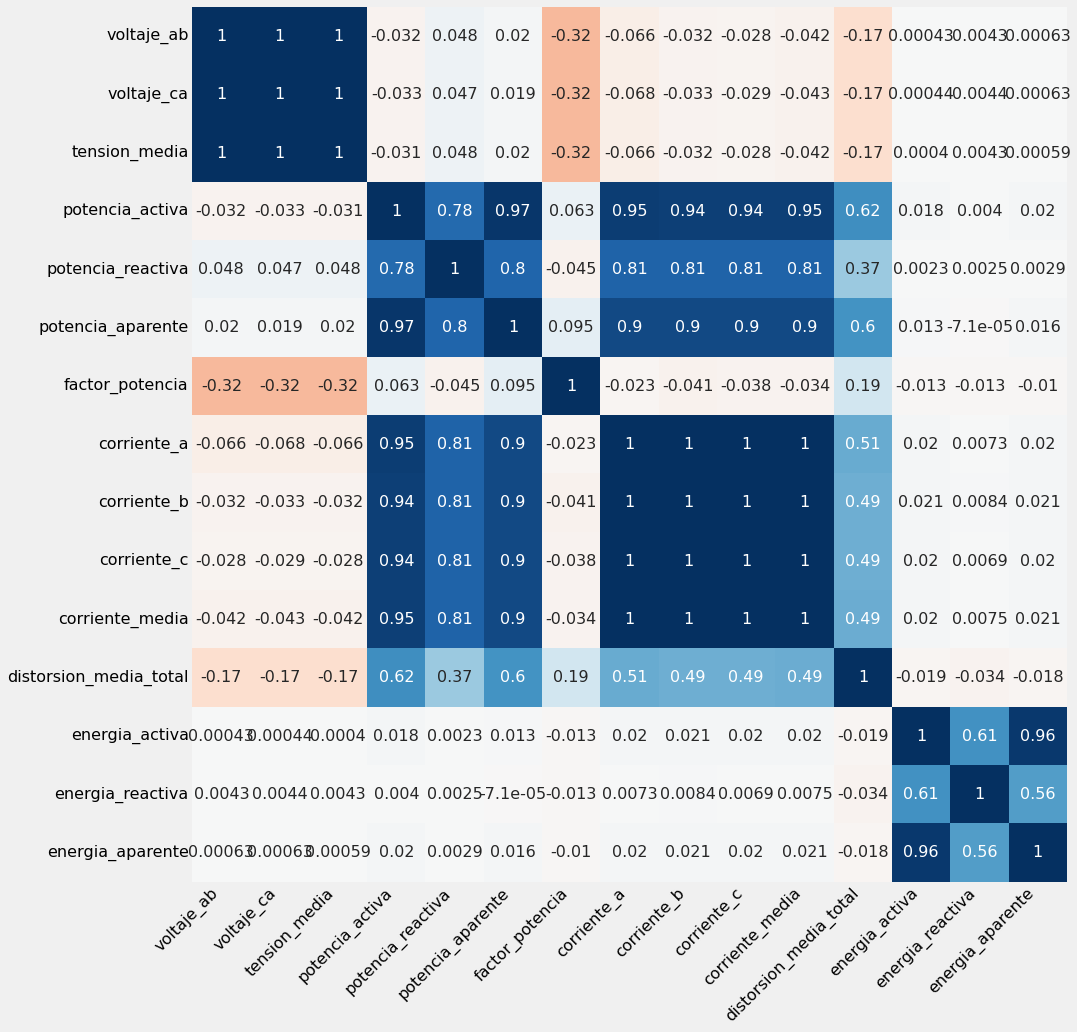

In [111]:
numCols = data_hour.select_dtypes(include = ['float64']).columns.tolist()
matrizCorr = data_hour[numCols].corr()
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))

sns.heatmap(
    matrizCorr,
    annot     = True,
    cbar      = False,
    annot_kws = {"size": 16},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = 'RdBu', #sns.diverging_palette(20, 220, n=200),
    square    = True,
    ax        = ax
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right',
)

ax.tick_params(labelsize = 16)

In [112]:
data_hour.head()

,date,hour,voltaje_ab,voltaje_ca,tension_media,potencia_activa,potencia_reactiva,potencia_aparente,factor_potencia,corriente_a,corriente_b,corriente_c,corriente_media,distorsion_media_total,energia_activa,energia_reactiva,energia_aparente
0,2023-10-10,10/10/2023 10:00:00 p. m.,394.710000,394.603333,394.543333,223.016667,118.146667,256.820000,0.356667,567.166667,591.973333,590.373333,583.363333,143.476667,213.0,112.9,245.3
1,2023-10-10,10/10/2023 11:00:00 p. m.,395.026667,394.810000,394.803333,202.803333,105.683333,233.190000,0.423333,522.010000,543.193333,547.070000,537.396667,130.223333,608.1,319.4,698.4
2,2023-10-10,10/10/2023 1:00:00 p. m.,394.426667,394.390000,394.393333,198.350000,84.566667,228.573333,0.923333,449.456667,467.510000,466.816667,461.263333,155.956667,71.5,33.3,82.7
3,2023-10-10,10/10/2023 2:00:00 p. m.,393.076667,392.976667,393.020000,176.336667,81.733333,207.716667,0.910000,401.376667,414.450000,418.743333,411.523333,133.173333,528.7,265.3,623.0
4,2023-10-10,10/10/2023 3:00:00 p. m.,393.300000,393.253333,393.280000,152.430000,74.170000,185.166667,0.936667,365.103333,375.923333,379.930000,373.593333,134.233333,457.2,245.0,555.6


In [113]:
#Sacar la variable de salida, 

#y = data_hour[]

### Agrupando por días

In [114]:
data_day = df_filtrado.groupby(["date"]).agg({
 "voltaje_ab"            : "mean",
 "voltaje_bc"            : "mean",
 "voltaje_ca"            : "mean",
 "tension_media"         : "mean",
 "potencia_activa"       : "mean",
 "potencia_reactiva"     : "mean",
 "potencia_aparente"     : "mean",
 "factor_potencia"       : "mean",
 "corriente_a"           : "mean",
 "corriente_b"           : "mean",
 "corriente_c"           : "mean",
 "corriente_media"       : "mean",
 "distorsion_media_total": "mean",
 "energia_activa"        : "sum",
 "energia_reactiva"      : "sum",
 "energia_aparente"      : "sum"
}).reset_index()

Correlación entre las variables

In [115]:
data_day.corr()

,date,voltaje_ab,voltaje_bc,voltaje_ca,tension_media,potencia_activa,potencia_reactiva,potencia_aparente,factor_potencia,corriente_a,corriente_b,corriente_c,corriente_media,distorsion_media_total,energia_activa,energia_reactiva,energia_aparente
date,1.000000,-0.346263,-0.346365,-0.344130,-0.345598,-0.049085,-0.231139,-0.073060,0.191035,-0.134597,-0.152668,-0.155534,-0.147850,0.293794,-0.017463,-0.031364,-0.014993
voltaje_ab,-0.346263,1.000000,0.999962,0.999879,0.999981,0.036869,0.167261,0.103975,-0.666877,0.005096,0.051793,0.056451,0.038250,-0.217824,-0.011123,0.000208,-0.012049
voltaje_bc,-0.346365,0.999962,1.000000,0.999855,0.999973,0.039733,0.170911,0.107067,-0.664776,0.008328,0.054848,0.059714,0.041434,-0.214713,-0.011280,0.000046,-0.012206
voltaje_ca,-0.344130,0.999879,0.999855,1.000000,0.999945,0.035771,0.165716,0.102847,-0.667578,0.003535,0.050089,0.054865,0.036632,-0.216630,-0.011065,0.000216,-0.011980
tension_media,-0.345598,0.999981,0.999973,0.999945,1.000000,0.037455,0.167964,0.104629,-0.666436,0.005648,0.052240,0.057007,0.038768,-0.216399,-0.011156,0.000157,-0.012078
potencia_activa,-0.049085,0.036869,0.039733,0.035771,0.037455,1.000000,0.880458,0.993086,0.185267,0.974401,0.973450,0.972420,0.973994,0.638486,0.015467,0.004797,0.015507
potencia_reactiva,-0.231139,0.167261,0.170911,0.165716,0.167964,0.880458,1.000000,0.909944,0.070581,0.914961,0.920980,0.923228,0.920327,0.469417,-0.013428,-0.014460,-0.014128
potencia_aparente,-0.073060,0.103975,0.107067,0.102847,0.104629,0.993086,0.909944,1.000000,0.144977,0.970521,0.972165,0.972425,0.972301,0.629753,0.008384,-0.000908,0.008497
factor_potencia,0.191035,-0.666877,-0.664776,-0.667578,-0.666436,0.185267,0.070581,0.144977,1.000000,0.217326,0.170040,0.169831,0.185424,0.414992,-0.010544,-0.022248,-0.009211
corriente_a,-0.134597,0.005096,0.008328,0.003535,0.005648,0.974401,0.914961,0.970521,0.217326,1.000000,0.997792,0.997398,0.998972,0.548404,0.012087,0.004633,0.011614


## Aplicando modelo de Arima A la data por día

Verificando el incremento cronológico

In [116]:
# verificando el incremento cronológico

if data_day['date'].is_monotonic_increasing:
    print("La columna 'date' está ordenada cronológicamente.")
else:
    print("La columna 'date' NO está ordenada cronológicamente.")

La columna 'date' está ordenada cronológicamente.


Visualizamos la serie, para tener una ilustración y realizar una observación.

In [117]:
# escogemos la serie a analizar
df_er = data_day[['date','energia_reactiva']]

In [118]:
df_er.head()

,date,energia_reactiva
0,2023-10-10,2153.4
1,2023-10-11,7805.1
2,2023-10-12,5532.7
3,2023-10-13,7926.3
4,2023-10-14,8061.5


In [119]:
df_er.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262 entries, 0 to 261
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              262 non-null    datetime64[ns]
 1   energia_reactiva  262 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 4.2 KB


In [120]:
# Visualiza la serie temporal

#plt.plot(data_day['date'], df_er)
fig = px.line(df_er, x='date', y='energia_reactiva', title='Energía Reactiva en el Tiempo')

# Personalización del gráfico
fig.update_layout(
    title='Energía Reactiva en el Tiempo',
    xaxis_title='Fecha',
    yaxis_title='Energía Reactiva',
    xaxis_rangeslider_visible=True,  # Agregar slider para seleccionar el rango de fechas
    width=1400,
    height=800
)

fig.show()


Vemos que hay un dato que está muy por encima del resto de los datos. 

Encontramos el dato y la fecha, se procede a consultar con el experto en datos de Auralac. 

Un sensor se daño y reportaba el mismo dato, 143 registros en total que tienen ese problema. 

In [121]:
# Calculamos el valos máximo de la serie
max_value_index  =  df_er["energia_reactiva"].idxmax()
imagen_value_max =  data_day.loc[max_value_index, 'energia_reactiva']
max_value_date   =  data_day.loc[max_value_index, 'date']
# Muestra la fecha del valor máximo
print(f"La fecha y el valor máximo de energía reactiva es: {max_value_date}, {imagen_value_max}")

La fecha y el valor máximo de energía reactiva es: 2024-01-10 00:00:00, 3084156.9


### Inputación eligiendo valor

para la inputación de los datos consideramos la media, la moda y la mediana, elegimos la que mejor se acomode 

In [122]:
moda    = df_er["energia_reactiva"].mode()
mediana = df_er["energia_reactiva"].median()
media   = df_er["energia_reactiva"].mean()
print(mediana,media)

8737.400000000001 20094.203435114505


In [123]:
df_er["energia_reactiva"].describe()

count    2.620000e+02
mean     2.009420e+04
std      1.900424e+05
min      8.960000e+01
25%      7.942800e+03
50%      8.737400e+03
75%      9.143600e+03
max      3.084157e+06
Name: energia_reactiva, dtype: float64

Claramente vemos que el valor promedio está muy por encima de los cuartiles. 

In [124]:
df_er["energia_reactiva"].iloc[max_value_index] = mediana
df_er["energia_reactiva"].describe()

/tmp/ipykernel_12159/1819503334.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



count      262.000000
mean      8355.961069
std       2668.757918
min         89.600000
25%       7942.800000
50%       8737.000000
75%       9138.800000
max      34107.000000
Name: energia_reactiva, dtype: float64

In [125]:
df_er["energia_reactiva"].iloc[max_value_index] = media
df_er["energia_reactiva"].describe()

/tmp/ipykernel_12159/4040952571.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



count      262.000000
mean      8399.307647
std       2765.455158
min         89.600000
25%       7942.800000
50%       8737.400000
75%       9143.600000
max      34107.000000
Name: energia_reactiva, dtype: float64

Dado que la desviación estandar es menor con la mediana, esto nos indica que tenemos una menor variabilidad con los datos, por lo cual elegimos inputación con la mediana.

In [126]:


# Gráfico 2: Usando todo el dataset o un segundo subconjunto
fig2 = px.line(df_er, x='date', y='energia_reactiva', title='Energía Reactiva en el Tiempo')

# Personalización del gráfico 2
fig2.update_layout(
    title='Energía Reactiva en el Tiempo',
    xaxis_title='Fecha',
    yaxis_title='Energía Reactiva',
    xaxis_rangeslider_visible=True,  # Agregar slider para seleccionar el rango de fechas
    width=1400,
    height=800
)

# Mostrar el gráfico 2
fig2.show()

El rango está entre 18 mil y 24 mil, la mitad de la energía activa, mas de la mitad de la energía reactiva en comparación de la energía activa. 
2. Si la energia reactiva supera a la energía activa es un dato erroneo.
3. Los dos picos los podemos reemplazar.
4. El registro 19 es una anomalia.
5. Corregir con los datos de EPM, 

In [127]:
data_day["energia_activa"].head(28)

0      4336.4
1     15731.9
2     11811.5
3     16471.1
4     16297.5
5     16296.2
6      9824.8
7     16464.6
8      2148.1
9      8218.0
10    13980.7
11    10204.9
12     3863.9
13    14752.8
14    11444.9
15     7630.0
16     7164.7
17    11700.1
18     9336.0
19      165.8
20     7173.6
21    12111.0
22    17922.4
23    18198.6
24    11216.1
25    14743.4
26    17156.6
27    38906.3
Name: energia_activa, dtype: float64

In [128]:
data_day[data_day["energia_activa"] < data_day["energia_reactiva"]]

,date,voltaje_ab,voltaje_bc,voltaje_ca,tension_media,potencia_activa,potencia_reactiva,potencia_aparente,factor_potencia,corriente_a,corriente_b,corriente_c,corriente_media,distorsion_media_total,energia_activa,energia_reactiva,energia_aparente
88,2024-01-09,325.39950,325.256000,325.345333,325.332917,162.005333,72.525667,185.164,0.697167,405.127500,408.730833,406.820583,406.896167,125.96750,32976.0,34107.0,37563.1
89,2024-01-10,323.72875,323.639667,323.721583,323.696750,171.600667,71.706500,191.908,0.720500,418.131583,423.643083,419.747250,420.509000,125.97825,1679608.1,3084156.9,1612139.6


Hasta noviembre de 2023 parece que la serie se está

In [129]:
df_er["energia_reactiva"][(df_er["energia_reactiva"] >= 0) & (df_er["energia_reactiva"] <= 100)]


19    89.6
Name: energia_reactiva, dtype: float64

In [130]:
Q1 = df_er["energia_reactiva"].quantile(0.25)
Q3 = df_er["energia_reactiva"].quantile(0.75)
IQR = Q3 - Q1

# Definir límites para detectar outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identificar los outliers
outliers = df_er["energia_reactiva"][(df_er["energia_reactiva"] < lower_bound) | (df_er["energia_reactiva"] > upper_bound)]

In [131]:
outliers

0       2153.400000
2       5532.700000
6       4522.200000
8       1225.300000
9       3942.500000
10     11809.800000
11      4708.500000
12      2017.000000
14      5449.800000
15      3251.900000
16      3699.500000
17      5008.100000
18      4440.100000
19        89.600000
20      3646.200000
21      5247.700000
24      5371.500000
27     26169.600000
28     16625.700000
30      4428.900000
34      6066.000000
36      5364.400000
37      4597.500000
66      6101.800000
72      5170.900000
78      2202.000000
85      5973.000000
88     34107.000000
89     20094.203435
90      4122.900000
93      5425.700000
97      2731.700000
98      5714.200000
120      295.700000
121     3612.200000
183     4342.900000
Name: energia_reactiva, dtype: float64

<Axes: >

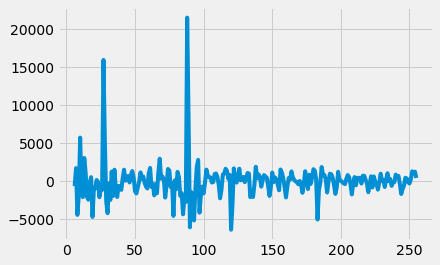

In [132]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(df_er["energia_reactiva"], model='additive', period=12)
residual = decomposition.resid
residual.plot()

In [133]:
from statsmodels.tsa.stattools import adfuller

# Realizar la prueba de Dickey-Fuller Aumentada
result = adfuller(df_er["energia_reactiva"])
print(f'Estadístico de ADF: {result[0]}')
print(f'p-valor: {result[1]}')
print('Critical Values:', result[4])

Estadístico de ADF: -10.131569191954382
p-valor: 8.889662895465194e-18
Critical Values: {'1%': -3.4557539868570775, '5%': -2.8727214497041422, '10%': -2.572728476331361}


Cómo el p-valor es extremadamente pequeño y el ADF es más pequeño que todos los valores críticos lo cual nos muestra que la serie es estacionaria.



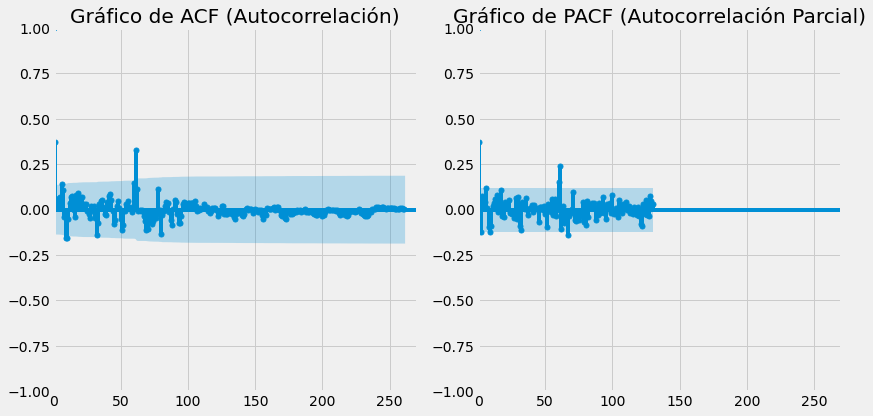

In [134]:
# Si la serie es estacionaria, puedes graficar directamente
# Energía reactiva
# Graficar ACF y PACF
plt.figure(figsize=(12, 6))

# Gráfico de ACF para seleccionar q
plt.subplot(121)
plot_acf(df_er["energia_reactiva"], ax=plt.gca(), lags=261)
#plt.ylim([-0.1,0.1])
plt.xlim([0,270])
plt.title('Gráfico de ACF (Autocorrelación)')

# Gráfico de PACF para seleccionar p
plt.subplot(122)
plot_pacf(df_er["energia_reactiva"], ax=plt.gca(), lags=130)
#plt.ylim([-0.1,0.1])
plt.xlim([0,270])
plt.title('Gráfico de PACF (Autocorrelación Parcial)')

plt.tight_layout()
plt.show()

Cómo la serie es estacionaria según la prueba de Dickey-Fuller Aumentada, no es necesario diferenciar la serie por lo cual $d=0$.

El corte en el gráfico PACF en el rezago 1 sugiere que el modelo tiene un término autogresivo de orden 1.

El corte en el gráfico ACF en el rezago 1 indica que el modelo tiene un término de media móvil de orden 1.

Ah sí los parametros para aplicar nuestro modelo ARIMA son $p=1$, $q=1$ y $d=0$

### Aplicando el modelo ARIMA(1, 0, 1)

In [135]:

# Ajustar el modelo ARIMA(1, 0, 1)
model = ARIMA(df_er["energia_reactiva"], order=(1,0, 1))
model_fit = model.fit()

# Resumen del modelo
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:       energia_reactiva   No. Observations:                  262
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -2424.955
Date:                Wed, 13 Nov 2024   AIC                           4857.910
Time:                        21:50:06   BIC                           4872.184
Sample:                             0   HQIC                          4863.647
                                - 262                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       8399.3076    307.352     27.328      0.000    7796.909    9001.707
ar.L1          0.0814      0.121      0.672      0.502      -0.156       0.319
ma.L1          0.3568      0.092      3.884      0.0

### Interpretación de las Estadísticas del modelo:

1. Coeficientes del modelo:
    1. ar.L1(coeficiente autoregresivo p = 1): 0.0814, con un p-valor de 0.502. El coeficiente no es significativo porque el p-valor es mucho mayor a 0.05. Esto sugiere que el componente autoregresivo no está constribuyendo significativamente al modelo 
    2. ma.L1: (coeficiente de media móvil q=1): 0.3568, con un p-valor de 0.0000 lo que indica que el componente de media móvil está jugando un papel importante en el ajuste del modelo.
    3. const: 8399.31, que parece representar la media o nivel alrededor del cual fluctúan los datos.
2. Pruebas de diagnóstico: 
    1. Ljuang-Box(Q): 0.02, con un p-valor de 0.90, Verifica si los rediduos están correlacionados. Un p-valor alto indica queno hay autocorrelación significativa en los residuos, lo cual es bueno porque el modelo ha capturado adecuadamente la estrucura de la serie. 
    2. Los valores de AIC y el BIC están bastante cerca, lo que sugiere que el modelo no está sobreajustado.

### Verificando el Overfitting

In [136]:
predicciones = model_fit.predict(start=0, end=len(df_er["energia_reactiva"])-1)


In [137]:
predicciones

0      8399.307628
1      6023.540716
2      8973.709411
3      6941.515466
4      8712.034363
          ...     
257    7953.530382
258    8167.553858
259    8039.188725
260    7724.078392
261    7931.052572
Name: predicted_mean, Length: 262, dtype: float64

In [138]:
predicciones_futuras = model_fit.get_forecast(steps=10)
intervalos_confianza = predicciones_futuras.conf_int()

# Extraer la predicción central (media), límite inferior y límite superior
prediccion_media = predicciones_futuras.predicted_mean
limite_inferior = intervalos_confianza.iloc[:, 0]
limite_superior = intervalos_confianza.iloc[:, 1]

In [139]:
predicciones = model_fit.predict(start=0, end=len(df_er["energia_reactiva"])-1)

mae = mean_absolute_error(df_er["energia_reactiva"], predicciones)#predicciones_futuras
mae

mse = mean_squared_error(df_er["energia_reactiva"], predicciones)
print(f'MSE: {mse}')

# Calcular RMSE (Root Mean Squared Error)
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')

# Calcular MAPE (Mean Absolute Percentage Error)
mape = np.mean(np.abs((df_er["energia_reactiva"] - predicciones) / df_er["energia_reactiva"])) * 100
print(f'MAPE: {mape}%')

MSE: 6427954.782197332
RMSE: 2535.341156964351
MAPE: 58.67010198787004%


In [140]:
import plotly.graph_objects as go

# Crear un DataFrame con los resultados
pred_df = pd.DataFrame({
    'Predicciones': prediccion_media,
    'Límite Inferior': limite_inferior,
    'Límite Superior': limite_superior
})


#df_er["date"].index[-1]
#len(pred_df)+1
# Asignar un índice de fechas adecuado para las predicciones
pred_df["date"] = pd.date_range(start=df_er["date"][df_er["date"].index[-1]], periods=len(pred_df)+1, freq='D')[1:]
pred_df
## Crear el gráfico con Plotly
fig = go.Figure()
#
## Agregar los valores históricos de energía reactiva
fig.add_trace(go.Scatter(x=df_er.index, y=df_er['energia_reactiva'], mode='lines', name='Valores Reales'))
#
## Agregar las predicciones
fig.add_trace(go.Scatter(x=pred_df.index, y=pred_df['Predicciones'], mode='lines', name='Predicciones'))
#
## Agregar el intervalo de confianza (Límite Inferior y Superior)
fig.add_trace(go.Scatter(
    x=pred_df.index, y=pred_df['Límite Inferior'], mode='lines', 
    line=dict(color='gray'), name='Límite Inferior', fill=None))

fig.add_trace(go.Scatter(
    x=pred_df.index, y=pred_df['Límite Superior'], mode='lines', 
    line=dict(color='gray'), name='Límite Superior', fill='tonexty', fillcolor='rgba(128, 128, 128, 0.2)'))

# Título y etiquetas
fig.update_layout(title="Predicciones de Energía Reactiva con Intervalos de Confianza",
                  xaxis_title="Fecha", yaxis_title="Energía Reactiva")

# Mostrar el gráfico
fig.show()


<Axes: title={'center': 'Residuos del modelo ARIMA(1,0,1)'}>

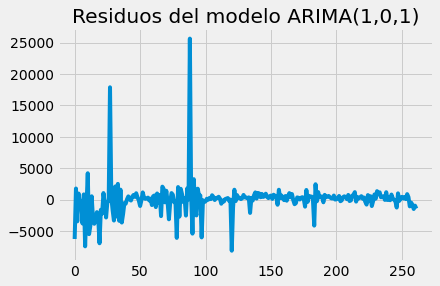

In [141]:
residuals = model_fit.resid
residuals.plot(title="Residuos del modelo ARIMA(1,0,1)")

In [142]:
model = ARIMA(df_er["energia_reactiva"], order=(0, 0, 1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:       energia_reactiva   No. Observations:                  262
Model:                 ARIMA(0, 0, 1)   Log Likelihood               -2425.123
Date:                Wed, 13 Nov 2024   AIC                           4856.247
Time:                        21:50:06   BIC                           4866.952
Sample:                             0   HQIC                          4860.549
                                - 262                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       8399.3076    291.072     28.856      0.000    7828.818    8969.798
ma.L1          0.4224      0.074      5.722      0.000       0.278       0.567
sigma2       6.31e+06   1.45e+05     43.638      0.0

### Interpretación de las Estadísticas del modelo:

1. Coeficientes del modelo:
    1. ar.L1(coeficiente autoregresivo p = 1): 0.0814

<Axes: title={'center': 'Residuos del modelo ARIMA(0,0,1)'}>

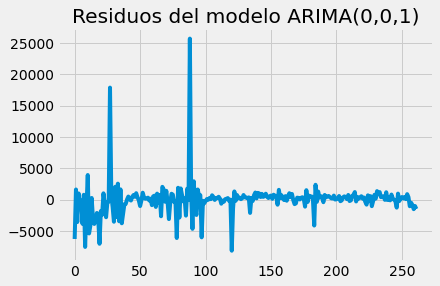

In [143]:
residuals = model_fit.resid
residuals.plot(title="Residuos del modelo ARIMA(0,0,1)")

In [144]:
from arch import arch_model

# Ajustar un modelo GARCH(1,1) a los residuos
garch_model = arch_model(residuals, vol='Garch', p=1, q=1)
garch_fit = garch_model.fit()

# Resumen del modelo GARCH
print(garch_fit.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 6101.1629956245415
Iteration:      2,   Func. Count:     14,   Neg. LLF: 2386.381125640769
Iteration:      3,   Func. Count:     19,   Neg. LLF: 2395.0610054379326
Iteration:      4,   Func. Count:     26,   Neg. LLF: 2386.3533461443667
Iteration:      5,   Func. Count:     31,   Neg. LLF: 2386.3419361560254
Iteration:      6,   Func. Count:     36,   Neg. LLF: 2386.284982923781
Iteration:      7,   Func. Count:     41,   Neg. LLF: 2386.003422349768
Iteration:      8,   Func. Count:     46,   Neg. LLF: 2384.675584566907
Iteration:      9,   Func. Count:     51,   Neg. LLF: 2379.9812944756773
Iteration:     10,   Func. Count:     56,   Neg. LLF: 2377.9952024818654
Iteration:     11,   Func. Count:     61,   Neg. LLF: 2377.947456518831
Iteration:     12,   Func. Count:     66,   Neg. LLF: 2377.9473850718405
Iteration:     13,   Func. Count:     71,   Neg. LLF: 2377.9473874210917
Optimization terminated successfully    (Exit mode 0)
  

/home/javier/.local/lib/python3.10/site-packages/arch/univariate/base.py:311: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 6.435e+06. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.01 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.




In [145]:
# Re-escalar los residuos o la serie que estás modelando
scaled_residuals = residuals / 1e6

# Ajustar el modelo GARCH de nuevo
garch_model = arch_model(scaled_residuals, vol='Garch', p=1, q=1)
garch_fit = garch_model.fit()
print(garch_fit.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 3951299419421862.0
Iteration:      2,   Func. Count:     21,   Neg. LLF: 3.3208257597261344e+17
Iteration:      3,   Func. Count:     36,   Neg. LLF: 7.177622843447805e+21
Iteration:      4,   Func. Count:     46,   Neg. LLF: -1198.2175913740202
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -1198.2175832622593
            Iterations: 5
            Function evaluations: 46
            Gradient evaluations: 4
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                1198.22
Distribution:                  Normal   AIC:                          -2388.44
Method:            Maximum Likelihood   BIC:                          -2374.16
                  

/home/javier/.local/lib/python3.10/site-packages/arch/univariate/base.py:311: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 6.435e-06. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 1000 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/home/javier/.local/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning:

The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.




<Axes: title={'center': 'Residuos estandarizados del modelo GARCH'}>

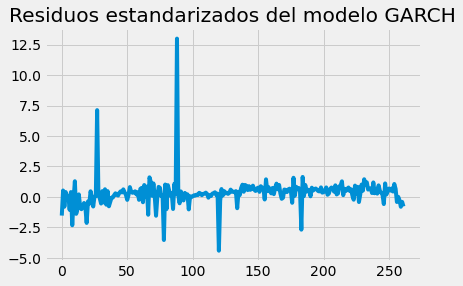

In [146]:
# Residuos estandarizados
residuals_std = garch_fit.resid / garch_fit.conditional_volatility
residuals_std.plot(title="Residuos estandarizados del modelo GARCH")

# Modelos Arima en los datos por hora

Verificando el incremento cronológico

In [147]:
if data_hour['date'].is_monotonic_increasing:
    print("La columna 'date' está ordenada cronológicamente.")
else:
    print("La columna 'date' NO está ordenada cronológicamente.")

La columna 'date' está ordenada cronológicamente.


In [148]:
# escogemos la serie a analizar
df_erh = data_hour[['energia_reactiva','date']]

In [149]:
df_erh.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5921 entries, 0 to 5920
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   energia_reactiva  5921 non-null   float64       
 1   date              5921 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1)
memory usage: 92.6 KB


In [150]:
# Visualiza la serie temporal

#plt.plot(data_day['date'], df_er)
fig = px.line(df_erh, x='date', y='energia_reactiva', title='Energía Reactiva en el Tiempo')

# Personalización del gráfico
fig.update_layout(
    title='Energía Reactiva en el Tiempo',
    xaxis_title='Fecha',
    yaxis_title='Energía Reactiva',
    xaxis_rangeslider_visible=True,  # Agregar slider para seleccionar el rango de fechas
    width=1400,
    height=800
)

fig.show()

In [151]:
# Calculamos el valos máximo de la serie
max_value_index = df_erh["energia_reactiva"].idxmax()
imagen_value_max =  df_erh.loc[max_value_index, 'energia_reactiva']
max_value_date = df_erh.loc[max_value_index, 'date']
# Muestra la fecha del valor máximo
print(f"La fecha y el valor máximo de energía reactiva es: {max_value_date}, {imagen_value_max}")

La fecha y el valor máximo de energía reactiva es: 2024-01-10 00:00:00, 302048.5


In [152]:
mediana = df_erh["energia_reactiva"].median()

In [153]:
df_erh["energia_reactiva"].iloc[max_value_index] = mediana
df_erh["energia_reactiva"].describe()

/tmp/ipykernel_12159/2905052112.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



count      5921.000000
mean        838.202888
std       10530.368580
min           0.000000
25%         331.800000
50%         366.500000
75%         398.200000
max      293910.500000
Name: energia_reactiva, dtype: float64

In [154]:
#plt.plot(data_day['date'], df_er)
fig = px.line(df_erh, x='date', y='energia_reactiva', title='Energía Reactiva en el Tiempo')

# Personalización del gráfico
fig.update_layout(
    title='Energía Reactiva en el Tiempo',
    xaxis_title='Fecha',
    yaxis_title='Energía Reactiva',
    xaxis_rangeslider_visible=True,  # Agregar slider para seleccionar el rango de fechas
    width=1400,
    height=800
)

# 
fig.show()

In [155]:
df_erh["energia_reactiva"].iloc[max_value_index]

366.5

# Graficos de EPM y sensores 

In [156]:
#plt.plot(data_day['date'], df_er)
# Gráfico 1: Usando un subconjunto específico de datos
fig1 = px.line(df_energia_epm, x='date', y='reactiva_inductiva', title='Energía Reactiva en el Tiempo (Subconjunto)')

# Personalización del gráfico 1
fig1.update_layout(
    title='Energía Reactiva en el Tiempo EPM (Subconjunto)',
    xaxis_title='Fecha',
    yaxis_title='Energía Reactiva Inductiva',
    xaxis_rangeslider_visible=True,  # Agregar slider para seleccionar el rango de fechas
    width=1400,
    height=800
)

# Mostrar el gráfico 1
fig1.show()

# # Gráfico 2: Usando todo el dataset o un segundo subconjunto
# fig2 = px.line(df_er, x='date', y='energia_reactiva', title='Energía Reactiva en el Tiempo')

# # Personalización del gráfico 2
# fig2.update_layout(
#     title='Energía Reactiva en el Tiempo',
#     xaxis_title='Fecha',
#     yaxis_title='Energía Reactiva',
#     xaxis_rangeslider_visible=True,  # Agregar slider para seleccionar el rango de fechas
#     width=1400,
#     height=800
# )

# # Mostrar el gráfico 2
# fig2.show()

ValueError: Value of 'x' is not the name of a column in 'data_frame'. Expected one of ['activa_consumo', 'activa_generación', 'reactiva_capacitiva', 'reactiva_inductiva', 'reactiva_inductiva_diff', 'reactiva_inductiva_diff2'] but received: date

# Deep Learning

In [ ]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, SimpleRNN
import math
from sklearn.metrics import mean_squared_error

In [ ]:
training_set

array([[ 1382.],
       [ 7072.],
       [ 7640.],
       ...,
       [ 9768.],
       [ 9944.],
       [10704.]], dtype=float16)

In [ ]:
# Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

In [ ]:
from utils.DataPreparationRNN import create_dataset
look_back = 10
X_train, y_train = create_dataset(training_set_scaled, look_back)
print(X_train.shape)
print(y_train.shape)

(1393, 10)
(1393,)


In [ ]:
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.3))
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='adam',loss='mean_squared_error')
# Fitting to the training set
regressor.fit(X_train.reshape(X_train.shape[0],look_back,1),y_train,epochs=50,batch_size=32)

In [ ]:
# The RNN architecture
model = Sequential()
# First RNN layer with Dropout regularisation
model.add(SimpleRNN(units=50,input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.2))
# The output layer
model.add(Dense(units=1))

2024-11-05 04:22:30.016048: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/javier/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 50)             │         2,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,651 (10.36 KB)

 Trainable params: 2,651 (10.36 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compiling the RNN
model.compile(optimizer='adam',loss='mean_squared_error')
# Fitting to the training set
model.fit(X_train.reshape(X_train.shape[0],look_back,1),y_train,epochs=50,batch_size=32)

Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0345   
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0141 
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0094 
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0099
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0076
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0073
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0079 
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0070 
Epoch 9/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0071 
Epoch 10/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step - loss: 0.0071
Epoch 11/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0064
Epoch 12/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0069 
Epoch 13/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0069
Epoch 14/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step - loss: 0.0065
Epoch 15/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0065 
Epoch

In [ ]:
df_energia_epm_total = pd.concat((df_energia_epm["reactiva_inductiva"][:'2023'],df_energia_epm["reactiva_inductiva"]['2024':]),axis=0)
inputs = df_energia_epm_total[len(df_energia_epm_total)-len(test_set) - look_back:].values
inputs[np.isnan(inputs)] = df_energia_epm['reactiva_inductiva'].max()
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)
inputs.shape

(275, 1)

In [ ]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(look_back,inputs.shape[0]):
    X_test.append(inputs[i-look_back:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


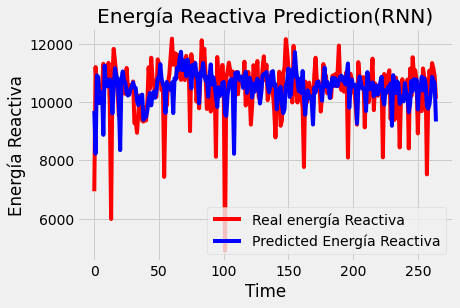

In [ ]:
# Visualizing the results
plt.plot(test_set, color='red',label='Real energía Reactiva')
plt.plot(predicted_stock_price, color='blue',label='Predicted Energía Reactiva')
plt.title('Energía Reactiva Prediction(RNN)')
plt.xlabel('Time')
plt.ylabel('Energía Reactiva')
plt.legend()
plt.show()

In [ ]:
# Evaluating our model

rmse = math.sqrt(mean_squared_error(test_set, predicted_stock_price))
print("The root mean squared error is {}.".format(rmse))
r2 = math.sqrt(r2_score(test_set, predicted_stock_price))
print("The r2 score is {}.".format(r2))

The root mean squared error is 926.3228378918443.
The r2 score is 1.0.


/home/javier/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1198: RuntimeWarning:

overflow encountered in square



### LSTM

In [ ]:
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.3))
regressor.add(Dense(units=1))

/home/javier/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [ ]:
regressor.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=150, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.3))
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='adam',loss='mean_squared_error')
# Fitting to the training set
regressor.fit(X_train.reshape(X_train.shape[0],look_back,1),y_train,epochs=50,batch_size=32)

Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1343
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0080
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0067
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0070
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0071
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0069
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0071
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0069
Epoch 9/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0066
Epoch 10/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0071
Epoch 11/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0063
Epoch 12/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0070
Epoch 13/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0065
Epoch 14/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0066
Epoch 15/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0070
Epoch 16/50
44/44 ━

In [ ]:
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


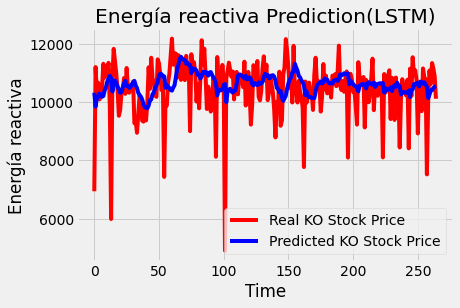

In [ ]:
# Visualizing the results
plt.plot(test_set, color='red',label='Real KO Stock Price')
plt.plot(predicted_stock_price, color='blue',label='Predicted KO Stock Price')
plt.title('Energía reactiva Prediction(LSTM)')
plt.xlabel('Time')
plt.ylabel('Energía reactiva')
plt.legend()
plt.show()

In [ ]:
# Evaluating our model
rmse = math.sqrt(mean_squared_error(test_set, predicted_stock_price))
print("The root mean squared error is {}.".format(rmse))

r2 = math.sqrt(r2_score(test_set, predicted_stock_price))
print("The r2 score is {}.".format(r2))

The root mean squared error is 957.4086118267372.
The r2 score is 1.0.


/home/javier/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1198: RuntimeWarning:

overflow encountered in square

